# AHDB wheat lodging risk and recommendations
This example notebook was inspired by the [AHDB lodging practical guidelines](https://ahdb.org.uk/knowledge-library/lodging): we evaluate the lodging risk for a field and output practical recommendations. We then adjust the estimated risk according to the Leaf Area Index (LAI) and Green Cover Fraction (GCF) obtained using the Agrimetrics GraphQL API.

## AHDB lodging resistance score
AHDB's guidelines show how a lodging resistance score can be calculated based on:
- the crop variety's natural resistance to lodging without Plant Growth Regulators (PGR)
- the soil Nitrogen Suply (SNS) index, a higher supply increases lodging risk
- the sowing date, an earlier sowing increases lodging risk
- the sowing density, higher plant density increases lodging risk

The overall lodging resistance score is the sum of the individual scores. AHDB practical advice on reducing the risk of lodging is given for 4 resistance score categories:

| Lodging resistance category | Lodging risk |
|---|---|
| below 5 | very high |
| 5-6.8 | high |
| 7-8.8 | medium |
| 9-10 | low |
| over 10 | very low |


In [1]:
# Input AHDB factors for evaluating lodging risks
def sns_index_score(sns_index):
    return 3 - 6 * sns_index / 4

# Sowing dates and associated lodging resistance score
sowing_date_scores = {'Mid Sept': -2, 'End Sept': -1, 'Mid Oct': 0, 'End Oct': 1, 'Nov onwards': 2}

# Density ranges and associated lodging resistance score
sowing_density_scores = {'<150': 1.5, '200-150': +0.75, '300-200': 0, '400-300': -1, '>400': -1.75}

# AHDB resistance score categories
def score_category(score):
    if score < 5:
        return 'below 5'
    if score < 7:
        return '5-6.8'
    if score < 9:
        return '7-8.8' 
    if score < 10:
        return '9-10'
    return 'over 10'

# Combine individual factor scores
def lodging_resistance_category(resistance_score, sns_index, sowing_date, sowing_density):
    score = resistance_score + sns_index_score(sns_index) + sowing_date_scores[sowing_date] + sowing_density_scores[sowing_density]
    return score_category(score)

## AHDB practical advice
AHDB provides practical advice for managing the risk of stem and root lodging. This advice depends on the resistance score calculated specifically for a field. AHDB recommends fertilizer and PGR actions for managing stem lodging risk. For root lodging, AHDB also advises if the crop needs to be rolled (before the crop has reached stage "GS30").

In [2]:
# Nitrogen fertiliser advice for stem risk
stem_risk_N_advice = {
    'below 5': 'Delay & reduce N',
    '5-6.8': 'Delay & reduce N',
    '7-8.8': 'Delay N',
}

# PGR advice for stem risk
stem_risk_PGR_advice = {
    'below 5': 'Full PGR',
    '5-6.8': 'Full PGR',
    '7-8.8': 'Single PGR',
    '9-10': 'PGR if high yield forecast'
}

# Nitrogen fertiliser advice for root risk
root_risk_N_advice = {
    'below 5': 'Reduce N',
    '5-6.8': 'Reduce N',
}

# PGR advice for root risk
root_risk_PGR_advice = {
    'below 5': 'Full PGR',
    '5-6.8': 'Full PGR',
    '7-8.8': 'Single PGR',
    '9-10': 'PGR if high yield forecast'
}

# Spring rolling advice for root risk
root_risk_Roll_advice = {
    'below 5': 'Roll',
    '5-6.8': 'Roll',
    '7-8.8': 'Roll',
}

## AHDB standard lodging risk management recommendations
Using the definitions above, we can calculate the AHDB recommendation according to individual factors:

In [3]:
import pandas as pd
from ipywidgets import widgets

style = {'description_width': 'initial'}

def ahdb_lodging_recommendation(resistance_score, sns_index, sowing_date, sowing_density):
    category = lodging_resistance_category(resistance_score, sns_index, sowing_date, sowing_density)
    return pd.DataFrame(index=['Fertiliser nitrogen', 'Plant growth regulators', 'Spring rolling'], data={
        'Stem lodging': [stem_risk_N_advice.get(category, ''), stem_risk_PGR_advice.get(category, ''), '' ],
        'Root lodging': [root_risk_N_advice.get(category, ''), root_risk_PGR_advice.get(category, ''), root_risk_Roll_advice.get(category, '')]
    })

widgets.interact(ahdb_lodging_recommendation,
    resistance_score = widgets.IntSlider(description='Resistance score without PGR', min=1, max=9, style=style),
    sns_index = widgets.IntSlider(description='SNS index', min=0, max=4, style=style),
    sowing_date = widgets.SelectionSlider(description='Sowing date', options=sowing_date_scores.keys(), style=style),
    sowing_density = widgets.SelectionSlider(description='Sowing density', options=sowing_density_scores.keys(), style=style),
)

interactive(children=(IntSlider(value=1, description='Resistance score without PGR', max=9, min=1, style=Slide…

<function __main__.ahdb_lodging_recommendation(resistance_score, sns_index, sowing_date, sowing_density)>

## Adjusting recommendations based on remote sensing information
The same practical guidelines from AHDB explains that crop conditions in Spring can indicate future lodging risk. In particular, Green Area Index (GAI) greater than 2 or Ground Cover Fraction (GCF) above 60% are indicative of increased stem lodging risk. For adjusting our practical advice, we will retrieve LAI and GCF from Agrimetrics GraphQL API.

### Using Agrimetrics GraphQL API
An Agrimetrics API key must be provided with each GraphQL API in a custom request header Ocp-Apim-Subscription-Key. For more information about how to obtain and use an Agrimetrics API key, please consult the [Developer portal](https://developer.agrimetrics.co.uk). To get started with GraphQL, see [Agrimetrics Graph Explorer](https://app.agrimetrics.co.uk/#/graph-explorer) tool.

In [6]:
import os
import requests

GRAPHQL_ENDPOINT = "https://api.agrimetrics.co.uk/query-api/v1/graphql"

if "API_KEY" in os.environ:
    API_KEY = os.environ["API_KEY"]
else:
    API_KEY = input("Query API Subscription Key: ").strip()

A GraphQL query is posted to the GraphQL endpoint in a json body. With our first query, we retrieve the Agrimetrics field id at a given location.

In [7]:
graphql_url = 'https://api.agrimetrics.co.uk/graphql'
headers = {
    'Ocp-Apim-Subscription-Key': API_KEY,
    'Content-Type': "application/json",
    'Accept-Encoding': "gzip, deflate, br",
}

centroid = (-0.929365345, 51.408374978)
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        query getFieldAtLocation($centroid: CoordinateScalar!) {
            fields(geoFilter: {location: {type: Point, coordinates: $centroid}, distance: {LE: 10}}) {
                id
            }
        }
    ''',
    'variables': {
        'centroid': centroid
    }
})
response.raise_for_status()
field_id = response.json()['data']['fields'][0]['id']
print('Agrimetrics field id:', field_id)

Agrimetrics field id: https://data.agrimetrics.co.uk/fields/BZwCrEVaXO62NTX_Jfl1yw


GraphQL API supports filtering by object ids. Here, we retrieve the sowing crop information associated to the field id obtained in our first query.

In [8]:
# Verify field was a wheat crop in 2018
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        query getSownCrop($fieldId: [ID!]!) {
            fields(where: {id: {EQ: $fieldId}}) {
                sownCrop {
                    cropType
                    harvestYear
                }
            }
        }
    ''',
    'variables': {
        'fieldId': field_id
    }
})
response.raise_for_status()
print(response.json()['data']['fields'][0]['sownCrop'])

[{'cropType': 'WHEAT', 'harvestYear': 2016}, {'cropType': 'MAIZE', 'harvestYear': 2017}, {'cropType': 'WHEAT', 'harvestYear': 2018}]


It is necessary to register for accessing Verde crop observations on our field of interest. LAI is a crop-specific attribute, so it is necessary to provide `cropType` when registering.

In [9]:
# Register for CROP_SPECIFIC verde data on our field
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        mutation registerCropObservations($fieldId: ID!) {
            account {
                premiumData {
                    addCropObservationRegistrations(registrations: {fieldId: $fieldId, layerType: CROP_SPECIFIC, cropType: WHEAT, season: SEP2017TOSEP2018}) {
                        id
                    }
                }
            }
        }
    ''',
    'variables': {'fieldId': field_id}
})
response.raise_for_status()

GCF is not crop specific, so we need to register as well for accessing non crop-specific attributes.

In [10]:
# Register for NON_CROP_SPECIFIC verde data on our field
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        mutation registerCropObservations($fieldId: ID!) {
            account {
                premiumData {
                    addCropObservationRegistrations(registrations: {fieldId: $fieldId, layerType: NON_CROP_SPECIFIC, season: SEP2017TOSEP2018}) {
                        id 
                    }
                }
            }
        }
    ''',
    'variables': {'fieldId': field_id}
})
response.raise_for_status()

Once Verde data for this field is available, we can easily retrieve it, for instance:

In [11]:
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        query getCropObservations($fieldId: [ID!]!) {
            fields(where: {id: {EQ: $fieldId}}) {
                cropObservations {
                    leafAreaIndex { dateTime mean }
                }
            }
        }
    ''',
    'variables': {'fieldId': field_id}
})
response.raise_for_status()

The data can be loaded as a pandas DataFrame:

In [12]:
results = response.json()
leafAreaIndex = pd.io.json.json_normalize(
    results['data']['fields'],
    record_path=['cropObservations', 'leafAreaIndex'],
)
leafAreaIndex['date_time'] = pd.to_datetime(leafAreaIndex['dateTime'])
leafAreaIndex['value'] = leafAreaIndex['mean']
leafAreaIndex = leafAreaIndex[['date_time', 'value']]
leafAreaIndex.head()

,date_time,value
0,2017-09-14 10:52:14+00:00,1.489300
1,2017-11-23 11:13:49+00:00,0.388411
2,2017-11-28 11:14:11+00:00,0.393542
3,2017-12-08 11:14:41+00:00,0.479305
4,2017-12-18 11:14:51+00:00,0.510158


We proceed to a second similar query to obtain green vegetation cover fraction:

In [13]:
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        query getCropObservations($fieldId: [ID!]!) {
            fields(where: {id: {EQ: $fieldId}}) {
                cropObservations {
                    greenVegetationCoverFraction { dateTime mean }
                }
            }
        }
    ''',
    'variables': {'fieldId': field_id}
})
response.raise_for_status()
results = response.json()
greenCoverFraction = pd.io.json.json_normalize(
    results['data']['fields'],
    record_path=['cropObservations', 'greenVegetationCoverFraction'],
)
greenCoverFraction['date_time'] = pd.to_datetime(greenCoverFraction['dateTime'])
greenCoverFraction['value'] = greenCoverFraction['mean']
greenCoverFraction = greenCoverFraction[['date_time', 'value']]

A year of observations was retrieved:

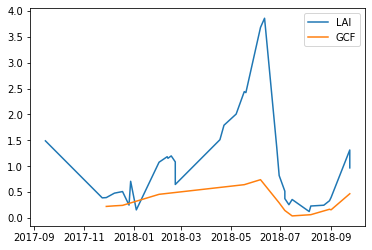

In [15]:
import matplotlib.pyplot as plt
plt.plot(leafAreaIndex['date_time'], leafAreaIndex['value'], label='LAI')
plt.plot(greenCoverFraction['date_time'], greenCoverFraction['value'], label='GCF')
plt.legend()
plt.show()

## Adjusting recommendation
GS31 marks the beginning of the stem elongation and generally occurs around mid April. Let's filter our LAI and GCF around this time of year:

In [16]:
from datetime import datetime, timezone
from_date = datetime(2018, 4, 7, tzinfo=timezone.utc)
to_date = datetime(2018, 4, 21, tzinfo=timezone.utc)
leafAreaIndex_mid_april = leafAreaIndex[(leafAreaIndex['date_time'] > from_date) & (leafAreaIndex['date_time'] < to_date)]
greenCoverFraction_mid_april = greenCoverFraction[(greenCoverFraction['date_time'] > from_date) & (greenCoverFraction['date_time'] < to_date)]

Check if LAI or GCF are above their respective thresholds:

In [17]:
(leafAreaIndex_mid_april['value'] > 2).any() | (greenCoverFraction_mid_april['value'] > 0.6).any()

False

Our field has an LAI below 2 in the 2 weeks around mid April and no GCF reading close enough to be taken into account. But we have now the basis for adjusting our recommendation by using Agrimetrics Verde crop observations. Let's broaden our evaluation to nearby Agrimetrics fields with a wheat crop in 2018.

In [18]:
response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        query getFieldsWithinRadius($centroid: CoordinateScalar!, $distance: Float!) {
            fields(geoFilter: {location: {type: Point, coordinates: $centroid}, distance: {LE: $distance}}) {
                id
                sownCrop {
                    cropType
                    harvestYear
                }
            }
        }
    ''',
    'variables': { 'centroid': centroid, 'distance': 2000 } # distance in m
})
response.raise_for_status()
results = response.json()
nearby_fields = pd.io.json.json_normalize(
    results['data']['fields'],
    record_path=['sownCrop'],
    meta=['id'],
)
nearby_wheat_fields = nearby_fields[(nearby_fields['cropType'] == 'WHEAT') 
                                    & (nearby_fields['harvestYear'] == 2018)]
available_fields = nearby_wheat_fields['id']
available_fields.head()

18    https://data.agrimetrics.co.uk/fields/4eOTI2Fo...
21    https://data.agrimetrics.co.uk/fields/6yu1VlwZ...
32    https://data.agrimetrics.co.uk/fields/A-cqD8Qb...
35    https://data.agrimetrics.co.uk/fields/BZwCrEVa...
55    https://data.agrimetrics.co.uk/fields/GWWGNhqT...
Name: id, dtype: object

Using the same approach as above, we implement the retrieval of Verde LAI and GCF for the selected fields:

In [19]:
def register(field_id):
    # Register for CROP_SPECIFIC verde data on our field
    response = requests.post(graphql_url, headers=headers, json={
        'query': '''
            mutation registerCropObservations($fieldId: ID!) {
                premiumDataAccess {
                    addCropObservationRegistrations(registrations: {
                        fieldId: $fieldId, layerType: CROP_SPECIFIC, season: SEP2017TOSEP2018, cropType: WHEAT
                    }) {
                        id
                    }
                }
            }
        ''',
        'variables': {'fieldId': field_id}
    })
    response.raise_for_status()
    # Register for NON_CROP_SPECIFIC verde data on our field
    response = requests.post(graphql_url, headers=headers, json={
        'query': '''
            mutation registerCropObservations($fieldId: ID!) {
                premiumDataAccess {
                    addCropObservationRegistrations(registrations: {
                        fieldId: $fieldId, layerType: NON_CROP_SPECIFIC, season: SEP2017TOSEP2018
                    }) {
                        id
                    }
                }
            }
        ''',
        'variables': {'fieldId': field_id}
    })
    response.raise_for_status()

def crop_observations(field_id, attribute):
    response = requests.post(graphql_url, headers=headers, json={
    'query': '''
        query getCropObservations($fieldId: [ID!]!) {{
            fields(where: {{id: {{EQ: $fieldId}}}}) {{
                cropObservations {{
                    {attribute} {{ mean dateTime }}
                }}
            }}
        }}
        '''.format(attribute=attribute),
        'variables': {'fieldId': field_id}
    })
    response.raise_for_status()
    results = response.json()
    data = pd.io.json.json_normalize(
        results['data']['fields'],
        record_path=['cropObservations', attribute],
    )
    data['date_time'] = pd.to_datetime(data['dateTime'])
    data['value'] = data['mean']
    return data[['date_time', 'value']]

def has_high_LAI(field_id, leafAreaIndex):
    if not leafAreaIndex.empty:
        leafAreaIndex_mid_april = leafAreaIndex[(leafAreaIndex['date_time'] > from_date) & (leafAreaIndex['date_time'] < to_date)]
        return (leafAreaIndex_mid_april['value'] > 2).any()
    return False

def has_high_GCF(field_id, greenCoverFraction):
    if not greenCoverFraction.empty:
        greenCoverFraction_mid_april = greenCoverFraction[(greenCoverFraction['date_time'] > from_date) & (greenCoverFraction['date_time'] < to_date)]
        return (greenCoverFraction_mid_april['value'] > 0.6).any()
    return False


We then revisit the recommendation algorithm:

In [20]:
def adjusted_lodging_recommendation(field_id, resistance_score, sns_index, sowing_date, sowing_density):
    register(field_id)
    leafAreaIndex = crop_observations(field_id, 'leafAreaIndex')
    greenCoverFraction = crop_observations(field_id, 'greenVegetationCoverFraction')
    
    high_LAI = has_high_LAI(field_id, leafAreaIndex)
    high_GCF = has_high_GCF(field_id, greenCoverFraction)
    
    plt.plot(leafAreaIndex['date_time'], leafAreaIndex['value'], label='LAI')
    plt.plot(greenCoverFraction['date_time'], greenCoverFraction['value'], label='GCF')
    plt.legend()
    plt.show()
    
    if high_LAI and high_GCF:
        print('High LAI and GCF were observed around GS31 for this crop, please consider adjusting the recommendation')
    elif high_LAI:
        print('High LAI was observed around GS31 for this crop, please consider adjusting the recommendation')
    elif high_GCF:
        print('High GCF was observed around GS31 for this crop, please consider adjusting the recommendation')
    else:
        print('High LAI and GCF were not observed around GS31 for this crop')

    return ahdb_lodging_recommendation(resistance_score, sns_index, sowing_date, sowing_density)

widgets.interact(adjusted_lodging_recommendation,
    field_id=widgets.Dropdown(description='Agrimetrics field id', options=available_fields, style=style), 
    resistance_score=widgets.IntSlider(description='Resistance score without PGR', min=1, max=9, style=style),
    sns_index=widgets.IntSlider(description='SNS index', min=0, max=4, style=style),
    sowing_date=widgets.SelectionSlider(description='Sowing date', options=sowing_date_scores.keys(), style=style),
    sowing_density=widgets.SelectionSlider(description='Sowing density', options=sowing_density_scores.keys(), style=style),
)

interactive(children=(Dropdown(description='Agrimetrics field id', options=('https://data.agrimetrics.co.uk/fi…

<function __main__.adjusted_lodging_recommendation(field_id, resistance_score, sns_index, sowing_date, sowing_density)>